In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class quaternion:
    def __init__(self, q0, q1, q2, q3):
        self.q0 = q0
        self.q = np.array([
            q1,
            q2,
            q3
        ])
        
    def __add__(self, other):
        new_q0 = self.q0 + other.q0
        new_q = self.q + other.q
        
        return quaternion(new_q0, *new_q)
    
    def __sub__(self, other):
        new_q0 = self.q0 - other.q0
        new_q = self.q - other.q
        
        return quaternion(new_q0, *new_q)
    
    def __mul__(self, other):
        if type(other) == type(self):
            new_q0 = self.q0*other.q0 - np.inner(self.q, other.q)
            new_q = self.q0*other.q + other.q0*self.q + np.cross(self.q, other.q)
        else:
            new_q0 = self.q0*other
            new_q = self.q*other
        
        return quaternion(new_q0, *new_q)
    
    def __truediv__(self, other):
        return quaternion(self.q0/other, *(-self.q/other))
    
    def __repr__(self):
        return f"{self.q0} + {self.q[0]}i + {self.q[1]}j + {self.q[2]}k"
    
    def conjugate(self):
        return quaternion(self.q0, *(-self.q))
    
    def norm(self):
        return np.sqrt(self.q0*self.q0 + np.square(self.q).sum())
    
    def inv(self):
        return self.conjugate()/np.square(self.norm())

#Efficient, only end effector pos

class Rotation:
    def __init__(self,in_place=False, theta=None, u=None):
        self.in_place = in_place
        
        if self.in_place:
            self.q = quaternion(np.cos(theta/2), *(np.sin(theta/2)*u))
            self.q_conjugate = self.q.conjugate()
            
        
    def __call__(self, v, theta=None, u=None):
        if not self.in_place:
            q = quaternion(np.cos(theta/2), *(np.sin(theta/2)*u))
            return q*v*q.conjugate()
        
        else:
            return self.q*v*self.q_conjugate
        
class joint_link:
    def __init__(self, theta, d, a, alpha, joint="r"):
        self.theta = theta
        self.d = d
        self.a = a
        self.alpha = alpha
        
        self.joint = joint
        
        self.link_len = quaternion(0, self.a, 0, 0)
        self.x_unit = np.array([1, 0, 0])
        self.y_unit = np.array([0, 1, 0])
        self.z_unit = np.array([0, 0, 1])
        
        self.R_alpha = Rotation(True, self.alpha, self.x_unit)
        
        if self.joint == "r":
            self.off_set = quaternion(0, 0, 0, self.d)
        else:
            self.R_theta = Rotation(True, self.theta, self.z_unit)
            
        self.R = Rotation(False)
        
    def __call__(self, variable=0., x=quaternion(0, 0, 0, 0)):
        x = self.R_alpha(x)
        x = x + self.link_len
        
        if self.joint == "r":
            x = x + self.off_set
            x = self.R(x, self.theta + variable, np.array([0, 0, 1]))
            
        elif self.joint == "p":
            x = x + quaternion(0, 0, 0, self.d + variable)
            x = self.R_theta(x)
        
        return x

In [3]:
#Gives values for animation

def Rotation(v, theta, u):
    q = quaternion(np.cos(theta/2), *(np.sin(theta/2)*u))
    return q*v*q.conjugate()


class joint_link:
    def __init__(self, theta, d, a, alpha, joint="r"):
        self.theta = theta
        self.d = d
        self.a = a
        self.alpha = alpha
        
        self.joint = joint
        
    def __call__(self, variable=0., link_pos=quaternion(0, 0, 0, 0), z=np.array([0, 0, 1]), x=np.array([1, 0, 0])):
        z_q = quaternion(0, *z)
        x_q = quaternion(0, *x)

        if self.joint == "r":
            x_q = Rotation(x_q, self.theta + variable, z_q.q)
            link_pos = link_pos + z_q*self.d
            
        elif self.joint == "p":
            x_q = Rotation(x_q, self.theta, z_q.q)
            link_pos = link_pos + z_q*(self.d + variable)

        link_pos = link_pos + x_q*self.a
        z_q = Rotation(z_q, self.alpha, x_q.q)

        return link_pos, z_q.q, x_q.q

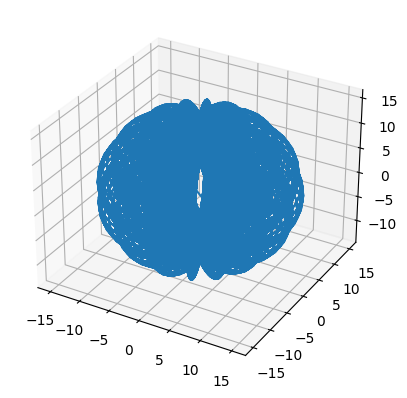

In [6]:
theta = np.pi/2
d = 0
a = 1
alpha = 0

points = []

l1 = joint_link(0, 1, 0, -np.pi/2)
l2 = joint_link(0, 0, 5, 0)
l3 = joint_link(0, 0, 10, 0)

for theta1 in np.arange(-np.pi, np.pi, np.pi/8):
    for theta2 in np.arange(-np.pi, np.pi, np.pi/16):
        for theta3 in np.arange(-np.pi, np.pi, np.pi/16):
            link_pos = l1(theta1)
            link_pos = l2(theta2, *link_pos)
            link_pos = l3(theta3, *link_pos)
            points.append(link_pos[0].q)

points = np.array(points)

ax = plt.axes(projection ='3d')
ax.plot3D(points[:, 0], points[:, 1], points[:, 2])
plt.show()

In [9]:
def cubic(tg, qs, qg, t):
    a2 = 3*(qg - qs)/tg**2
    a3 = -2*(qg - qs)/tg**3
    return qg if t>=tg else qs if t<0 else qs + a2*t**2 + a3*t**3

In [14]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

l1 = joint_link(0, 3, 0, np.pi/2)
l2 = joint_link(0, 0, 10, 0)
l3 = joint_link(np.pi/2, 0, 0, np.pi/2)

l4 = joint_link(0, 1+10, 0, -np.pi/2)
l5 = joint_link(-np.pi/2, 0, 1, -np.pi/2)
l6 = joint_link(0, 0, 1, 0)

def theta (t):
    t=t/10
    fig = plt.figure(figsize=(10,15))
    ax = plt.axes(projection ='3d')
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_zlim(-20, 20)
    
    pos = [[0, 0, 0]]
    # print(cubic(10, 0, np.pi, t))
    link_end, z, x = l1(cubic(10, 0, np.pi, t) if t<10 else 0)
    pos.append(link_end.q)

    link_end, z, x = l2(cubic(10, 0, np.pi, t-10) if t<20 else 0, link_end, z, x)
    pos.append(link_end.q)

    link_end, z, x = l3(cubic(10, 0, np.pi, t-20) if t<30 else 0, link_end, z, x)
    pos.append(link_end.q)

    link_end, z, x = l4(cubic(10, 0, np.pi, t-30) if t<40 else 0, link_end, z, x)
    pos.append(link_end.q)

    link_end, z, x = l5(cubic(10, 0, np.pi, t-40) if t<50 else 0, link_end, z, x)
    pos.append(link_end.q)

    link_end, z, x = l6(cubic(10, 0, np.pi, t-50) if t<60 else 0, link_end, z, x)
    pos.append(link_end.q)

    pos = np.array(pos)
    ax.plot3D(pos[:, 0], pos[:, 1], pos[:, 2],'red')
    plt.show()
    
widgets.interact(theta , t= widgets.Play(min=0,max =600, step=1));

interactive(children=(Play(value=0, description='t', max=600), Output()), _dom_classes=('widget-interact',))

In [ ]:

l1 = joint_link(0, 1, 0, np.pi/2)
l2 = joint_link(0, 0, 10, 0)
l3 = joint_link(0, 0, 10, 0)

pos = []

link_pos = l3(0)
pos.append(link_pos.q)

link_pos = l2(0, link_pos)
pos.append(link_pos.q)

link_pos = l1(np.pi/2, link_pos)
pos.append(link_pos.q)

pos = np.array(pos)

In [ ]:
pos

array([[1.00000000e+01, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+01, 0.00000000e+00, 0.00000000e+00],
       [3.55271368e-15, 2.00000000e+01, 1.00000000e+00]])

array([ 10.,  20., -20.])